In [1]:
import os
import pandas as pd

## Reading dataset

In [2]:
path = "archive/20news-19997/20_newsgroups"
df = []

for folder in os.listdir(path):
    for file in os.listdir(f'{path}/{folder}'):
        f = open(f'{path}/{folder}/{file}', 'rb')
        df.append({'text': f.read(), 'newsgroup': folder})

In [3]:
df = pd.DataFrame(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       19997 non-null  object
 1   newsgroup  19997 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [4]:
df.head()

,text,newsgroup
0,"b""Newsgroups: sci.space\nPath: cantaloupe.srv....",sci.space
1,b'Newsgroups: sci.space\nPath: cantaloupe.srv....,sci.space
2,"b""Newsgroups: sci.space\nPath: cantaloupe.srv....",sci.space
3,b'Newsgroups: sci.space\nPath: cantaloupe.srv....,sci.space
4,b'Newsgroups: sci.space\nPath: cantaloupe.srv....,sci.space


In [5]:
df["text"][0]

b"Newsgroups: sci.space\nPath: cantaloupe.srv.cs.cmu.edu!rochester!udel!bogus.sura.net!news-feed-1.peachnet.edu!gatech!swrinde!sdd.hp.com!ux1.cso.uiuc.edu!news.cso.uiuc.edu!uxa.cso.uiuc.edu!gfk39017\nFrom: gfk39017@uxa.cso.uiuc.edu (George F. Krumins)\nSubject: Re: space news from Feb 15 AW&ST\nDate: Fri, 23 Apr 1993 20:16:24 GMT\nMessage-ID: <C5yDnC.GwB@news.cso.uiuc.edu>\nReferences: <C5ros0.uy@zoo.toronto.edu> <1993Apr23.155313.4220@dazixco.ingr.com>\nSender: usenet@news.cso.uiuc.edu (Net Noise owner)\nOrganization: University of Illinois at Urbana\nLines: 23\n\njbreed@doink.b23b.ingr.com (James B. Reed) writes:\n\n>In article <C5ros0.uy@zoo.toronto.edu>, henry@zoo.toronto.edu (Henry Spencer) writes:\n>|> [Pluto's] atmosphere will start to freeze out around 2010, and after about\n>|> 2005 increasing areas of both Pluto and Charon will be in permanent\n>|> shadow that will make imaging and geochemical mapping impossible.\n\nIt's my understanding that the freezing will start to occur 

## Converting bytes to string

In [6]:
def bytes_to_str(text):
    return text.decode('utf-8', errors = 'ignore')
df["text"]=df["text"].apply(bytes_to_str)

In [7]:
df

,text,newsgroup
0,Newsgroups: sci.space\nPath: cantaloupe.srv.cs...,sci.space
1,Newsgroups: sci.space\nPath: cantaloupe.srv.cs...,sci.space
2,Newsgroups: sci.space\nPath: cantaloupe.srv.cs...,sci.space
3,Newsgroups: sci.space\nPath: cantaloupe.srv.cs...,sci.space
4,Newsgroups: sci.space\nPath: cantaloupe.srv.cs...,sci.space
...,...,...
19992,Xref: cantaloupe.srv.cs.cmu.edu soc.culture.tu...,talk.politics.mideast
19993,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,talk.politics.mideast
19994,Newsgroups: talk.politics.mideast\nPath: canta...,talk.politics.mideast
19995,Xref: cantaloupe.srv.cs.cmu.edu soc.culture.ar...,talk.politics.mideast


In [8]:
df["newsgroup"].nunique()

20

## Removing headers

In [9]:
def remove_header(text):
    split_text = text.split('\n\n', 1)
    if len(split_text) > 1:
        return split_text[1]
    return text
df["text"] = df["text"].apply(remove_header)

## Dividing into build and valid datasets

In [10]:
from sklearn.model_selection import train_test_split

print(df.shape)

X_build, X_val = train_test_split(
    df,
    test_size=0.3, random_state=213)

print("X_build shape: {}".format(X_build.shape))
print("X_val shape: {}".format(X_val.shape))

(19997, 2)
X_build shape: (13997, 2)
X_val shape: (6000, 2)


In [11]:
df = X_build.copy()
original_df = df.copy()

### Counting sentences

In [12]:
from nltk.tokenize import sent_tokenize
df["sentences"]=df["text"].apply(sent_tokenize).apply(len)

### Counting question and exclamation marks

In [13]:
df["question_marks_ratio"] = df["text"].str.count("\?")/df["sentences"]
df["exclamation_marks_ratio"] = df["text"].str.count("\!")/df["sentences"]

### Counting links

In [14]:
df["links"] = df["text"].str.count(r'https?://\S+|www\.\S+')

### Counting e-mail addresses

In [15]:
df["emails_addresses"] = df["text"].str.count(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')

## Cleaning

In [17]:
import string
import re

def clean(df):
    df["text"] = df['text'].str.replace('https?://\S+|www\.\S+', '', regex = True) # links
    df["text"] = df["text"].str.replace(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', '', regex = True) # e-mail adresses
    df["text"] = df['text'].str.replace('<.*?>+', '', regex = True) # tags
    df["text"] = df['text'].str.replace('\[.*?\]', '', regex = True) # square brackets
    df["text"] = df['text'].str.replace('[%s]' % re.escape(string.punctuation), '', regex = True) # puntuation marks
    df["text"] = df['text'].str.replace('\n', ' ', regex = True) # newline character
    df["text"] = df['text'].str.replace("\\W"," ", regex = True) # non-alphanumeric characters
    df["text"] = df['text'].str.replace('\w*\d\w*', '', regex = True) # numeric sequences
    df["text"] = df['text'].str.replace(r'\b\w\b', '', regex = True) # one-letter words
    df["text"] = df['text'].str.replace(r'\s+', ' ', regex = True) # empty spaces
    return df

df = clean(df)
df.head()

,text,newsgroup,sentences,question_marks_ratio,exclamation_marks_ratio,links,emails_addresses
12727,In article Robert Castro writes Would anyone o...,rec.motorcycles,14,0.071429,0.571429,0,3
12958,In article Jerry Hartzler CATS writes In artic...,rec.motorcycles,5,0.000000,0.000000,0,5
17116,try to unsubscribe from this group by sending...,comp.windows.x,4,0.250000,0.000000,0,1
6186,In article John Eaton writes Thats one problem...,sci.crypt,13,0.230769,0.000000,0,2
6782,The key question is whether nonClipper encrypt...,sci.crypt,16,0.125000,0.000000,0,1


## Converting to lowercase

In [18]:
df["chars"]=df["text"].str.len()
df["capital_letters_ratio"] = df["text"].str.count(r'[A-Z]')/df["text"].str.count(r'[A-za-z]')
df["text"] = df['text'].str.lower()

## Removing stopwords

In [19]:
from nltk.corpus import stopwords

def remove_stopwords(text):
 stop = set(stopwords.words('english'))
 text = [word for word in text.split() if word not in stop]
 text = ' '.join(x for x in text)
 return text

df['text'] = df['text'].apply(remove_stopwords)

## Cleaning missing data

In [20]:
df = df[(df["text"] != '') & (df["text"] != '[]')]

In [21]:
df["text"] = df["text"].apply(str)

/tmp/ipykernel_13011/1434408237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df["text"].apply(str)


## POS tagging and lemmatization

In [22]:
from nltk.corpus import wordnet
import nltk
from nltk.stem import WordNetLemmatizer

def pos_tag_and_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    lemmas = []
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    token_count = len(tokens)
    unique_words = len(set(tokens))

    if token_count == 0:
        return lemmas, noun_count, adj_count, verb_count, adv_count, token_count, unique_words

    lemmatizer = WordNetLemmatizer()

    for token, pos in pos_tags:
        wn_pos = nltk.corpus.wordnet.NOUN
        if pos.startswith('J'):
            wn_pos = wordnet.ADJ
            adj_count += 1
        elif pos.startswith('V'):
            wn_pos = wordnet.VERB
            verb_count += 1
        elif pos.startswith('R'):
            wn_pos = wordnet.ADV
            adv_count += 1
        else:
            noun_count += 1

        lemma = lemmatizer.lemmatize(token, pos=wn_pos)
        lemmas.append(lemma)

    noun_ratio = noun_count/token_count
    adj_ratio = adj_count/token_count
    verb_ratio = verb_count/token_count
    adv_ratio = adv_count/token_count

    lemmas = " ".join(lemmas)

    return lemmas, noun_ratio, adj_ratio, verb_ratio, adv_ratio, token_count, unique_words

# Apply POS-tagging, lemmatization, and count to the DataFrame
df[['text', 'noun_ratio', 'adj_ratio', 'verb_ratio', 'adv_ratio', 'words', 'unique_words']] = df['text'].apply(pos_tag_and_lemmatize).apply(pd.Series)

## Lexical diversity

In [23]:
df['lexical_div'] = df['words'] / df['unique_words']

## Average word length

In [24]:
df['avg_word_length'] = df['chars'] / df['words']

## Sentiment analysis

In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

# Calculate the sentiment scores for all texts
sentiment_scores = df['text'].apply(lambda text: sia.polarity_scores(text))

# Extract negative, positive, and neutral scores into separate columns
df['negative'] = sentiment_scores.apply(lambda score: score['neg'])
df['positive'] = sentiment_scores.apply(lambda score: score['pos'])
df['neutral'] = sentiment_scores.apply(lambda score: score['neu'])

In [26]:
df.head()

,text,newsgroup,sentences,question_marks_ratio,exclamation_marks_ratio,links,emails_addresses,chars,capital_letters_ratio,noun_ratio,adj_ratio,verb_ratio,adv_ratio,words,unique_words,lexical_div,avg_word_length,negative,positive,neutral
12727,article robert castro writes would anyone dodl...,rec.motorcycles,14,0.071429,0.571429,0,3,1335,0.058878,0.562044,0.167883,0.218978,0.051095,137,117,1.170940,9.744526,0.033,0.139,0.828
12958,article jerry hartzler cat write article micha...,rec.motorcycles,5,0.000000,0.000000,0,5,402,0.072508,0.538462,0.153846,0.205128,0.102564,39,36,1.083333,10.307692,0.068,0.093,0.839
17116,try unsubscribe group send email doesnt work c...,comp.windows.x,4,0.250000,0.000000,0,1,397,0.081818,0.595238,0.238095,0.142857,0.023810,42,40,1.050000,9.452381,0.027,0.107,0.867
6186,article john eaton write thats one problem far...,sci.crypt,13,0.230769,0.000000,0,2,1334,0.018051,0.583333,0.166667,0.191667,0.058333,120,109,1.100917,11.116667,0.129,0.218,0.653
6782,key question whether nonclipper encryption mak...,sci.crypt,16,0.125000,0.000000,0,1,1906,0.018657,0.479290,0.224852,0.242604,0.053254,169,134,1.261194,11.278107,0.120,0.231,0.649


## Scaling

In [27]:
df_numeric = df.select_dtypes(include=['float','int'])
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(df_numeric)
df_numeric = pd.DataFrame(scaler.transform(df_numeric), index=df_numeric.index,
                                 columns=df_numeric.columns)
df_numeric

,sentences,question_marks_ratio,exclamation_marks_ratio,links,emails_addresses,chars,capital_letters_ratio,noun_ratio,adj_ratio,verb_ratio,adv_ratio,words,unique_words,lexical_div,avg_word_length,negative,positive,neutral
12727,0.009630,0.007185,0.034632,0.0,0.011278,0.020549,0.058878,0.562044,0.223844,0.218978,0.059611,0.021411,0.056641,0.006030,0.208408,0.033,0.139,0.828
12958,0.002963,0.000000,0.000000,0.0,0.018797,0.006145,0.072508,0.538462,0.205128,0.205128,0.119658,0.005982,0.017090,0.002939,0.228839,0.068,0.093,0.839
17116,0.002222,0.025148,0.000000,0.0,0.003759,0.006067,0.081818,0.595238,0.317460,0.142857,0.027778,0.006455,0.019043,0.001764,0.197809,0.027,0.107,0.867
6186,0.008889,0.023213,0.000000,0.0,0.007519,0.020533,0.018051,0.583333,0.222222,0.191667,0.068056,0.018734,0.052734,0.003560,0.258188,0.129,0.218,0.653
6782,0.011111,0.012574,0.000000,0.0,0.003759,0.029364,0.018657,0.479290,0.299803,0.242604,0.062130,0.026448,0.064941,0.009213,0.264045,0.120,0.231,0.649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11051,0.002963,0.000000,0.000000,0.0,0.000000,0.003921,0.110577,0.458333,0.222222,0.333333,0.048611,0.003621,0.010742,0.001534,0.244886,0.000,0.273,0.727
17409,0.002222,0.025148,0.000000,0.0,0.003759,0.002949,0.136095,0.700000,0.200000,0.150000,0.000000,0.002991,0.009277,0.000000,0.208606,0.000,0.000,1.000
8032,0.002963,0.040237,0.024242,0.0,0.007519,0.003813,0.053398,0.560000,0.266667,0.240000,0.000000,0.003778,0.010742,0.003067,0.219127,0.000,0.087,0.913
13540,0.011852,0.005917,0.000000,0.0,0.018797,0.040248,0.045057,0.558333,0.238889,0.212500,0.058333,0.037626,0.090332,0.010241,0.249572,0.077,0.210,0.713


## Correlated numeric columns

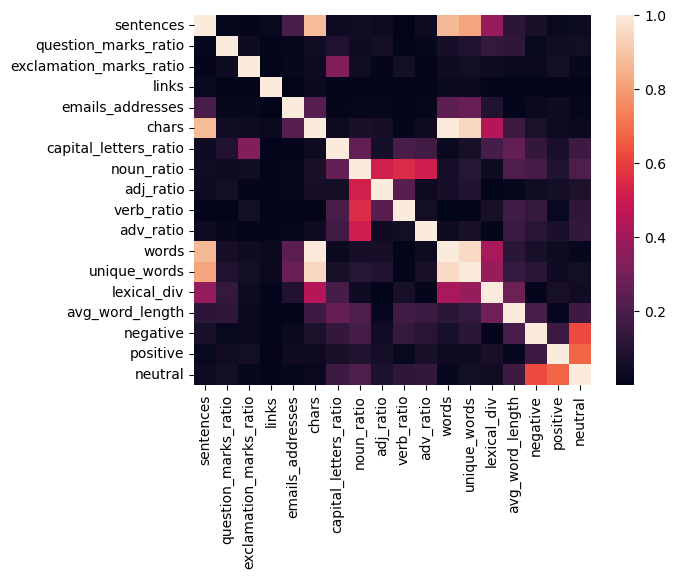

In [28]:
import numpy as np
import seaborn as sb

corr_matrix = df_numeric.corr(method="pearson").abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
dfplot = sb.heatmap(corr_matrix)

In [29]:
df_numeric = df_numeric.drop(to_drop, axis=1)
to_drop

['words', 'unique_words']

## Vectorizing

### CountVectorizer

In [30]:
import warnings
import re
from sklearn.feature_extraction.text import CountVectorizer

# Suppress the warning
warnings.filterwarnings("ignore", category=UserWarning)

count_vectorizer = CountVectorizer(stop_words = "english")
count_df = count_vectorizer.fit_transform(df["text"])
count_df

<13966x82215 sparse matrix of type '<class 'numpy.int64'>'
	with 1089507 stored elements in Compressed Sparse Row format>

### TfidfVectorizer

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features=7000)
tfidf_df = tfidf_vectorizer.fit_transform(df["text"])
tfidf_df

<13966x7000 sparse matrix of type '<class 'numpy.float64'>'
	with 889099 stored elements in Compressed Sparse Row format>

## Differences between vectorizers

In [32]:
count_df = pd.DataFrame(count_df.A, columns = count_vectorizer.get_feature_names_out())
tfidf_df = pd.DataFrame(tfidf_df.A, columns = tfidf_vectorizer.get_feature_names_out())
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

{'committ', 'badge', 'topoftheline', 'bullpens', 'kagramanov', 'batchlike', 'rumble', 'accuarate', 'branden', 'altreligion', 'dekorte', 'gentium', 'offerman', 'zener', 'sisler', 'noncriminals', 'basa', 'sonys', 'arrowing', 'winecj', 'winjpeg', 'ky', 'compdcommodemsall', 'spaceacronyms', 'subwindow', 'uncensored', 'binational', 'llctbwir', 'orignal', 'xinternatom', 'assured', 'whitaker', 'telcos', 'buting', 'wellbeing', 'fortay', 'lifesci', 'forgavest', 'thatyet', 'tbrape', 'landmark', 'acn', 'binoculars', 'whyisitthatway', 'cwi', 'slangslingslinkslickslackshackshankthankthinkthick', 'ploytm', 'eben', 'junkie', 'unum', 'hoogerdijk', 'sup', 'magnificently', 'xnews', 'usian', 'opinionbut', 'pleistocene', 'devon', 'taxula', 'termws', 'gorge', 'lxmusrc', 'sohc', 'sportscenter', 'starkly', 'phallicness', 'hade', 'stn', 'unjumpered', 'censured', 'inflect', 'accessability', 'cooked', 'rahmi', 'pukedspecifically', 'usamericanization', 'tandberg', 'slaby', 'ximage', 'stsdas', 'khmylevs', 'minebi

In [33]:
from scipy.sparse import hstack, csr_matrix

other_df = hstack([csr_matrix(df_numeric)])

In [34]:
other_df.shape

(13966, 16)

## Clustering using k-means

### tfidf_df

In [35]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters= 20, init='k-means++', max_iter=100, n_init=10)
km.fit(tfidf_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=100, n_clusters=20)

In [36]:
from sklearn import metrics
labels = df["newsgroup"]
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tfidf_df, km.labels_, sample_size=1000))

Homogeneity: 0.389
Completeness: 0.477
V-measure: 0.429
Adjusted Rand-Index: 0.116
Silhouette Coefficient: 0.008


In [38]:
centroids = km.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(20):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: car engine drive article dealer ford write look buy good
Cluster 1: monitor use mac apple machine problem work chip modem port
Cluster 2: write article say know think use like dont make people
Cluster 3: gun people government right fbi say law koresh article think
Cluster 4: drive scsi disk ide controller hard floppy problem use work
Cluster 5: card driver video ati bus diamond color mode graphic thanks
Cluster 6: key encryption chip clipper escrow use phone government algorithm nsa
Cluster 7: thanks email advance know hi address mail appreciate list reply
Cluster 8: game espn baseball hockey play playoff score win team fan
Cluster 9: bike dod motorcycle ride rider dog article write helmet rid
Cluster 10: god believe say jesus bible faith atheist write people exist
Cluster 11: window run use windows program application file manager version nt
Cluster 12: objective value moral morality odwyer frank say science people article
Cluster 13: israel israeli arab jew palestinian jew

### other_df

In [39]:
from sklearn.cluster import KMeans

km_other = KMeans(n_clusters= 20, init='k-means++', max_iter=100, n_init=10)
km_other.fit(other_df)

KMeans(max_iter=100, n_clusters=20, n_init=10)

In [40]:
from sklearn import metrics
labels = df["newsgroup"]
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km_other.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km_other.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km_other.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km_other.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(other_df, km_other.labels_, sample_size=1000))

Homogeneity: 0.055
Completeness: 0.060
V-measure: 0.057
Adjusted Rand-Index: 0.017
Silhouette Coefficient: 0.089
